In [57]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# must be >=2.6.2
tf.__version__
# !pip install --upgrade tensorflow

'2.6.2'

# Basic version of the Siamese Network

## parameters

In [15]:
target_shape = (200,200)
batch_size = 64

## input pipeline

In [27]:
def get_object(row, image):
    id_, x, y, w, h = row
    image_height,image_width = image.shape[0],image.shape[1]
    id_ = int(id_)
    x = int(max(x,0))
    y = int(max(y,0))
    w = int(min(w,image_width-x))
    h = int(min(h,image_height-y))
    if y == -1: y = 0
    if x == -1: x = 0
    obj = image[y:y+h,x:x+w]
    obj = cv2.resize(obj, dsize=target_shape, interpolation=cv2.INTER_CUBIC)
    obj = obj.astype(np.float32)
    obj /= 255.
    return obj

def triplet_gen(mode):
    # gt file header
    header = {"frame":0, "id":1, "x":2, "y":3, "w":4, "h":5, "x1":6, "x2":7, "conf":9}

    # get the list of gt files
    gt_files = sorted(glob.glob("data/train/*/*/gt.txt"))
    if mode == "train":
        gt_files = gt_files[:-1]
    elif mode == "val":
        gt_files = gt_files[-1:]
    else:
        raise RuntimeError("Invalid mode. It must be either 'train' or 'val'.")
        
    def gen():
        for gt_file in gt_files:
            gt = np.loadtxt(gt_file,delimiter=",")
            frames = np.unique(gt[:,header["frame"]])
            for frame in frames:
                image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(frame)))
                image = cv2.imread(image_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                gt_frame = gt[gt[:,header["frame"]] == frame]
    #             plt.figure(figsize=(20,20))
    #             plt.imshow(image)
    #             plt.show()
                for row in gt_frame:
                    positive_data = gt[gt[:,header["id"]] == row[header["id"]]]
                    positive_index = np.random.choice(len(positive_data), size=1)[0]
                    positive_row = positive_data[positive_index]
                    positive_frame = positive_row[header["frame"]]
                    positive_image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(positive_frame)))
                    positive_image = cv2.imread(positive_image_file)
                    positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
                    negative_data = gt_frame[gt_frame[:,header["id"]] != row[header["id"]]]
                    negative_index = np.random.choice(len(negative_data), size=1)[0]
                    negative_row = negative_data[negative_index]
                    anchor = get_object(row[1:6], image)
                    positive = get_object(positive_row[1:6], positive_image)
                    negative = get_object(negative_row[1:6], image)
                    yield anchor,positive,negative
    return gen

train_dataset = tf.data.Dataset.from_generator(triplet_gen("train"), (tf.float32,tf.float32,tf.float32), (target_shape + (3,),target_shape + (3,),target_shape + (3,)))
train_dataset = train_dataset.shuffle(buffer_size=2^14)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True) #TODO: should set to False?
train_dataset = train_dataset.prefetch(8)

val_dataset = tf.data.Dataset.from_generator(triplet_gen("val"), (tf.float32,tf.float32,tf.float32), (target_shape + (3,),target_shape + (3,),target_shape + (3,)))
val_dataset = val_dataset.shuffle(buffer_size=2^14)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True) #TODO: should set to False?
val_dataset = val_dataset.prefetch(8)

## siamese network
source:https://keras.io/examples/vision/siamese_network/

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import resnet


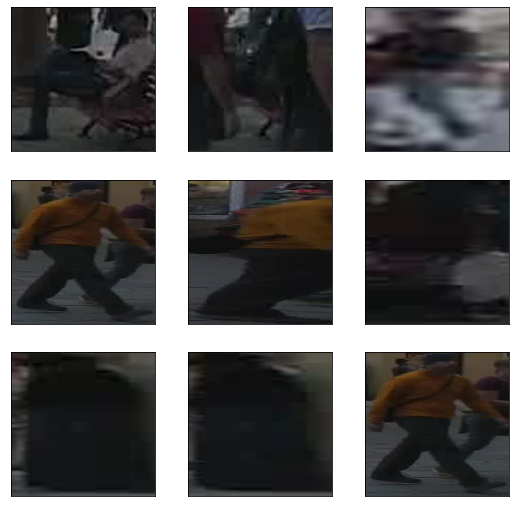

In [20]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

sample = next(iter(train_dataset))
visualize(*sample)

In [21]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [22]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [23]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
# about 6 hours per epoch with batch size of 64 I have about 1875 steps 
# (~20000 triplet per video, 6 video in training set) to take 
# TODO: parallelize?
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, batch_size = batch_size)

Epoch 1/10
     28/Unknown - 358s 12s/step - loss: 0.1989

In [ ]:

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

sample = next(iter(train_dataset))
visualize(*sample)

# Improved version of the Siamese Network
This one accepts the triplet location as input.

## parameters

In [3]:
target_shape = (200,200)
batch_size = 64

## input pipeline

In [4]:
def get_object_location(row, image):
    id_, x, y, w, h = row
    image_height,image_width = image.shape[0],image.shape[1]
    id_ = int(id_)
    x = int(max(x,0))
    y = int(max(y,0))
    w = int(min(w,image_width-x))
    h = int(min(h,image_height-y))
    if y == -1: y = 0
    if x == -1: x = 0
    obj = image[y:y+h,x:x+w]
    obj = cv2.resize(obj, dsize=target_shape)#, interpolation=cv2.INTER_CUBIC) #TODO : should I keep this interpolation?
    obj = obj.astype(np.float32)
    obj /= 255.
    return obj,np.array([x/image_width,y/image_height,w/image_width,h/image_height])

def triplet_gen(mode):
    # gt file header
    header = {"frame":0, "id":1, "x":2, "y":3, "w":4, "h":5, "x1":6, "x2":7, "conf":9}

    # get the list of gt files
    gt_files = sorted(glob.glob("data/train/*/*/gt.txt"))
    if mode == "train":
        gt_files = gt_files[:-1]
    elif mode == "val":
        gt_files = gt_files[-1:]
    else:
        raise RuntimeError("Invalid mode. It must be either 'train' or 'val'.")

    def gen():
        for gt_file in gt_files:
            gt = np.loadtxt(gt_file,delimiter=",")
            frames = np.unique(gt[:,header["frame"]])
            for frame in frames:
                image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(frame)))
                image = cv2.imread(image_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                gt_frame = gt[gt[:,header["frame"]] == frame]
    #             plt.figure(figsize=(20,20))
    #             plt.imshow(image)
    #             plt.show()
                for row in gt_frame:
                    positive_data = gt[gt[:,header["id"]] == row[header["id"]]]
                    positive_index = np.random.choice(len(positive_data), size=1)[0]
                    positive_row = positive_data[positive_index]
                    positive_frame = positive_row[header["frame"]]
                    positive_image_file = os.path.join(os.sep.join(gt_file.split(os.sep)[:-2]),"img1/{:06d}.jpg".format(int(positive_frame)))
                    positive_image = cv2.imread(positive_image_file)
                    positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
                    negative_data = gt_frame[gt_frame[:,header["id"]] != row[header["id"]]]
                    negative_index = np.random.choice(len(negative_data), size=1)[0]
                    negative_row = negative_data[negative_index]
                    anchor = get_object_location(row[1:6], image)
                    positive = get_object_location(positive_row[1:6], positive_image)
                    negative = get_object_location(negative_row[1:6], image)
                    yield anchor,positive,negative
    return gen


train_dataset = tf.data.Dataset.from_generator(triplet_gen("train"), ((tf.float32,tf.float32),(tf.float32,tf.float32),(tf.float32,tf.float32)), ((target_shape + (3,),(4,)),(target_shape + (3,),(4,)),(target_shape + (3,),(4,))))
train_dataset = train_dataset.shuffle(buffer_size=2^14)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True) #TODO: should set to False?
train_dataset = train_dataset.prefetch(8)

val_dataset = tf.data.Dataset.from_generator(triplet_gen("val"), ((tf.float32,tf.float32),(tf.float32,tf.float32),(tf.float32,tf.float32)), ((target_shape + (3,),(4,)),(target_shape + (3,),(4,)),(target_shape + (3,),(4,))))
val_dataset = val_dataset.shuffle(buffer_size=2^14)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True) #TODO: should set to False?
val_dataset = val_dataset.prefetch(8)

## siamese network
source:https://keras.io/examples/vision/siamese_network/

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


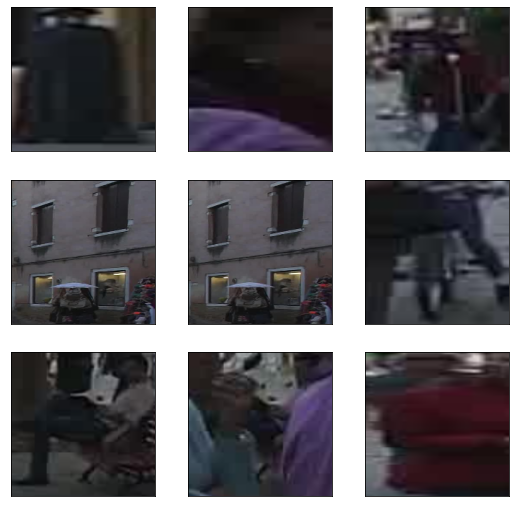

In [6]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

sample = next(iter(train_dataset))
visualize(sample[0][0],sample[1][0],sample[2][0])

In [43]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
location_input = layers.Input(shape=(4,))

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(256, activation="relu")(flatten) # TODO: made it simpler by going from 512 to 256
dense1 = layers.BatchNormalization()(dense1)
concat = layers.Concatenate()([dense1, location_input])
dense2 = layers.Dense(128, activation="relu")(concat) # TODO: made it simpler by going from 256 to 128
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(128)(dense2)# TODO: made it simpler by going from 256 to 128

embedding = Model([base_cnn.input,location_input], output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block3_out": #TODO: I change from block1 to block3 to reduce number of trainable params
        trainable = True
    layer.trainable = trainable

In [44]:
print(embedding.summary())

Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [45]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input_image = layers.Input(name="anchor_image", shape=target_shape + (3,))
positive_input_image = layers.Input(name="positive_image", shape=target_shape + (3,))
negative_input_image = layers.Input(name="negative_image", shape=target_shape + (3,))

anchor_input_location = layers.Input(name="anchor_location",shape=(4,))
positive_input_location = layers.Input(name="positive_location",shape=(4,))
negative_input_location = layers.Input(name="negative_location",shape=(4,))



distances = DistanceLayer()(
    embedding((resnet.preprocess_input(anchor_input_image), anchor_input_location)),
    embedding((resnet.preprocess_input(positive_input_image), positive_input_location)),
    embedding((resnet.preprocess_input(negative_input_image), negative_input_location)),
)

siamese_network = Model(
    inputs=[(anchor_input_image,   anchor_input_location),
            (positive_input_image, positive_input_location), 
            (negative_input_image, negative_input_location)],
    outputs=distances
)

In [46]:
print(siamese_network.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_image (InputLayer)       [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
positive_image (InputLayer)     [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
negative_image (InputLayer)     [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_19 (Sl (None, 200, 200, 3)  0           anchor_image[0][0]               
____________________________________________________________________________________________

In [47]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [60]:
# about 6 hours per epoch with batch size of 64 I have about 1875 steps 
# (~20000 triplet per video, 6 video in training set) to take 
# TODO: parallelize?
siamese_model = SiameseModel()
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, batch_size = batch_size)

Epoch 1/10
      9/Unknown - 95s 9s/step - loss: 0.1093

KeyboardInterrupt: 

In [70]:
# the lines to save and load siamese network
siamese_network.save("models/siamese_network_2/model_0")
# siamese_network = load_model("models/siamese_network_2/model_0")


Positive similarity: 0.99982727
Negative similarity 0.9996598


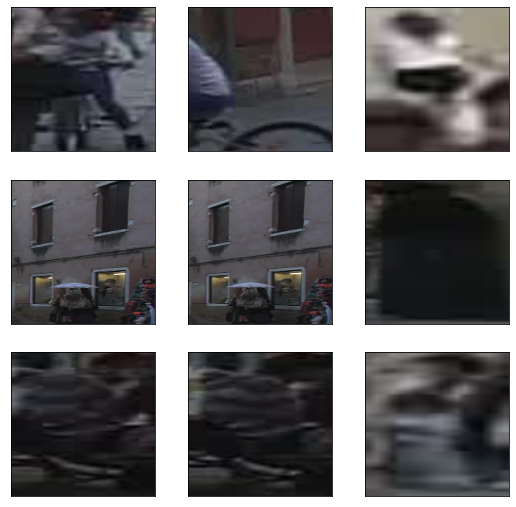

In [50]:
sample = next(iter(train_dataset))
anchor = sample[0]
positive = sample[1]
negative = sample[2]
visualize(anchor[0],positive[0],negative[0])


anchor_embedding, positive_embedding, negative_embedding = (
    embedding((resnet.preprocess_input(anchor[0]), anchor[1])),
    embedding((resnet.preprocess_input(positive[0]), positive[1])),
    embedding((resnet.preprocess_input(negative[0]),  negative[1])),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

